## Parte 1: Reglas de asociación ##

En el “groceries.csv” contiene las transacciones recogidas durante un mes en una tienda de
comestibles. En cada una de las filas de este archivo se encuentran los artículos comprados de
forma conjunta por los diferentes clientes. Obtener las lista de artículos que tiene un soporte
mínimo de 0,15. Obtener también las reglas de asociación que se pueden deducir de este
conjunto de datos con un soporte mínimo de 0,05 y confianza de 0,25.

### Importando los datos ###

In [10]:
import csv
import apriori

In [11]:
groceries = []
groceries_file = csv.reader(open("groceries.csv", "rb"))

for row in groceries_file:

    groceries.append(row)

### Obteniendo los artículos con soporte mínimo de 0.15 ###

In [12]:
F, soporte = apriori.apriori(groceries, min_support=0.15, verbose=True)

{soda}:  sup = 0.174
{whole milk}:  sup = 0.256
{other vegetables}:  sup = 0.193
{rolls/buns}:  sup = 0.184


### Obteniendo reglas de asociación ###

Deben de tener un soporte mínimo del 0.05 y una confianza del 0.25.

In [13]:
F, soporte = apriori.apriori(groceries, min_support=0.05)
H = apriori.generate_rules(F, soporte, min_confidence=0.25, verbose=True)

{yogurt} ---> {whole milk}:  conf = 0.402, sup = 0.056
{rolls/buns} ---> {whole milk}:  conf = 0.308, sup = 0.057
{other vegetables} ---> {whole milk}:  conf = 0.387, sup = 0.075
{whole milk} ---> {other vegetables}:  conf = 0.293, sup = 0.075


## Parte 2: Implementación de una regresión “stepwise” con eliminación hacia atrás. (40 puntos) ##

Utilizando el dataset de calidad de vinos blancos, realizar una implementación del del algoritmo con eliminación hacia atrás (Backward Stepwise Regression), en el que la selección de las variables se realiza empezando con un modelo que
utiliza todas la variables disponibles para ir eliminando en cada paso la produce el modelo menos significativo.

In [14]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [15]:
import pandas as pd

wine = pd.read_csv('winequality-white.csv', sep = ';')
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

# Separación de la variable objetivo y las explicativas
target = 'quality'
features = list(wine.columns)
features.remove('quality')

x = wine[features]
y = wine[target]

In [17]:
def backward_regression(x, y):
    
    # Obtencion del conjunto de datos para validación
    x_train, x_test, y_train, y_test = train_test_split(x, y)

    # Modelo para realizar los ajustes
    model = LinearRegression()

    # Almacenará todas las características y se irán eliminando por cada iteración
    features_aux = features[:]

    # Almacenará las características en el orden que se vayan eliminando
    features_sol = []

    # Contendrá el mínimo error de todas las posibilidades
    min_error = 1
    # Contendrá el nombre de la característica a borrar, es decir, la que al eliminarla genere
    # el modelo con menor error
    feature_remove = ""

    # Mientras queden características por eliminar
    while(len(features_aux) > 1):

        print("Todas las caracteristicas: " + str(features_aux) + "\n")

        # Para cada característica de la lista
        for i in features_aux:

            # Se escogen todas las que hay menos esa característica
            features_aux2 = features_aux[:]    
            features_aux2.remove(i)

            # Se escogen los datos
            use_train = x_train[features_aux2]
            use_test = x_test[features_aux2]

            # Se entrena el modelo y se obtiene el error
            model.fit(use_train, y_train)
            rmsError = np.linalg.norm((y_test - model.predict(use_test)), 2)/ sqrt(len(y_test))
            print("Tras eliminar caracteristica: " + i + ", Error: " + str(rmsError))

            # Se guardará la característica que, al quitarla (i seleccionada), de un menor error (mejor modelo),
            # para obtener la mejor combinación de características.
            if rmsError < min_error:
                min_error = rmsError
                feature_remove = i

        print("\nVariable a eliminar: " + feature_remove + " con un error de: " + str(min_error))
        # Se elimina la característica para la siguiente iteración y se añade a la lista solución
        features_aux.remove(feature_remove)
        features_sol.append(feature_remove)

        # Se reinicializan las variables acumuladoras
        feature_remove = ""
        min_error = 1

        print("--------------------------------------------------------\n")

    # En este punto el algoritmo habrá terminado dejando en la lista una única característica (la última).
    # Por lo tanto, hay que añadirla para completar la lista final
    features_sol.append(features_aux[0])

    # Se muestra el resultado.
    print("Solucion (orden de variables) : " + str(features_sol))
    

In [18]:
# Probando el ejercicio
backward_regression(x, y)

Todas las caracteristicas: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Tras eliminar caracteristica: fixed acidity, Error: 0.771398837409
Tras eliminar caracteristica: volatile acidity, Error: 0.793830998946
Tras eliminar caracteristica: citric acid, Error: 0.776361721633
Tras eliminar caracteristica: residual sugar, Error: 0.780504168803
Tras eliminar caracteristica: chlorides, Error: 0.776501814193
Tras eliminar caracteristica: free sulfur dioxide, Error: 0.780002433854
Tras eliminar caracteristica: total sulfur dioxide, Error: 0.776686095926
Tras eliminar caracteristica: density, Error: 0.775274930553
Tras eliminar caracteristica: pH, Error: 0.770355371076
Tras eliminar caracteristica: sulphates, Error: 0.775811910119
Tras eliminar caracteristica: alcohol, Error: 0.788961974113

Variable a eliminar: pH con un error de: 0.770355371076
----------------------

## Parte 3: Predicción de la miopía en una población. (50 puntos) ##

El archivo “myopia.csv” contiene los datos de un estudio realizado durante 5 años en los que se
siguió la salud ocular de una población. Los registros se corresponde con los valores tomados
inicialmente estudio y una variable "MYOPIC" en la que registra si al sujeto se le diagnostico
miopía durante el estudio. 

Las variables son:

- ID: Identificador ID
- STUDYYEAR: Año en los que se inició el estudio
- MYOPIC: Desarrollo miopía dentro de los primeros cinco años
- AGE: Edad a primera visita
- GENDER: Genero
- SPHEQ: Refracción esférica equivalente
- AL: Longitud Axial
- ACD: Profundidad de cámara anterior
- LT: Grosor de la lente
- VCD: Profundidad de cámara vítrea
- SPORTHR: ¿Cuántas horas por semana fuera de la escuela el niño participó en deportes o actividades al aire libre?
- READHR: ¿Cuántas horas por semana fuera de la escuela el niño pasó leyendo por placer?
- COMPHR: ¿Cuántas horas por semana fuera de la escuela el niño pasó jugando a videojuegos de ordenador o trabajando en el ordenador?
- STUDYHR: ¿Cuántas horas por semana fuera de escuela el niño pasa leyendo o estudiando para tareas escolares?
- TVHR: ¿Cuántas horas por semana fuera de la escuela el niño pasó mirando televisión?
- DIOPTERHR: Compendio de horas de actividades de trabajo cercano que se define como:
    - DIOPTERHR = 3 * (READHR + STUDYHR) + 2 * COMPHR + TVHR
- MOMMY: ¿La madre del sujeto es miope?
- DADMY: ¿El padre del sujeto es miope?

Crear un modelo que pueda predecir la aparición de miopía en el conjunto de estudio.

## Importando los datos ##

In [19]:
%pylab
%matplotlib inline
import pandas as pd
df = pd.read_csv("myopia.csv", sep = ";")
df.head(5)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


,ID,STUDYYEAR,MYOPIC,AGE,GENDER,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,1,1992,1,6,1,-0.052,21.89,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,2,1995,0,6,1,0.608,22.38,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,3,1991,0,6,1,1.179,22.49,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,4,1990,1,6,1,0.525,22.20,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,1995,0,5,0,0.697,23.29,3.676,3.454,16.16,14,0,0,0,4,4,1,0


## Identificar variable objetivo y cálculo de nulos ##

In [20]:
# Separar variable objetivo de las explicativas
target = 'MYOPIC'
features = list(df.columns)
features.remove(target)

In [21]:
# Se observa si existe nulos en las variables
sum(isnan(df))

ID           0
STUDYYEAR    0
MYOPIC       0
AGE          0
GENDER       0
SPHEQ        0
AL           0
ACD          0
LT           0
VCD          0
SPORTHR      0
READHR       0
COMPHR       0
STUDYHR      0
TVHR         0
DIOPTERHR    0
MOMMY        0
DADMY        0
dtype: int64

No existen nulos en ninguna de las variables.

### Eliminando variables identificadoras ###

In [22]:
# La variable id es identificadora, por lo que se elimina del conjunto de características.
features.remove("ID")

#### Analizando variables discretas ####

In [23]:
df[features].head(5)

,STUDYYEAR,AGE,GENDER,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,1992,6,1,-0.052,21.89,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,1995,6,1,0.608,22.38,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,1991,6,1,1.179,22.49,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,1990,6,1,0.525,22.20,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,1995,5,0,0.697,23.29,3.676,3.454,16.16,14,0,0,0,4,4,1,0


Se observan que las variables discretas son:
- STUDYYEAR
- AGE
- GENDER
- SPORTHR
- READHR
- COMPHR
- STUDYHR
- TVHR
- DIOPTERHR
- MOMMY
- DADMY

In [24]:
for var in ['STUDYYEAR', 'AGE', 'GENDER', 'SPORTHR', 'READHR', 'COMPHR', 'STUDYHR', 'TVHR', 'DIOPTERHR',
           'MOMMY','DADMY']:
    print "Tabla de frecuencias para:", var
    print pd.crosstab(df[target], df[var])
    print

Tabla de frecuencias para: STUDYYEAR
STUDYYEAR  1990  1991  1992  1993  1994  1995
MYOPIC                                       
0           114    88    78    90    88    79
1            17     9    10    21    15     9

Tabla de frecuencias para: AGE
AGE      5    6   7   8  9
MYOPIC                    
0       17  398  73  45  4
1        4   58   9   8  2

Tabla de frecuencias para: GENDER
GENDER    0    1
MYOPIC          
0       281  256
1        35   46

Tabla de frecuencias para: SPORTHR
SPORTHR  0   1   2   3   4   5   6   7   8   9  ...  30  31  32  33  35  36  \
MYOPIC                                          ...                           
0         8   4  19  16  31  35  30  33  30  18 ...  10   2   0   1   5   1   
1         3   3   6  10   2   6   2   7   2   2 ...   0   0   1   0   0   0   

SPORTHR  39  40  41  45  
MYOPIC                   
0         1   1   2   0  
1         0   0   0   1  

[2 rows x 40 columns]

Tabla de frecuencias para: READHR
READHR   0   1   2   

### Variable AGE: un nivel con pocos valores ###

In [25]:
def get_WoE(data, var, target):
    crosstab = pd.crosstab(data[target], data[var])
    
    print "Obteniendo el Woe para la variable", var, ":"
    
    for col in crosstab.columns:
        if crosstab[col][1] == 0:
            print "  El WoE para", col, "[", sum(crosstab[col]), "] es infinito"
        else:
            print "  El WoE para", col, "[", sum(crosstab[col]), "] es", np.log(float(crosstab[col][0]) / float(crosstab[col][1]))

In [26]:
get_WoE(df, "AGE" , target)

Obteniendo el Woe para la variable AGE :
  El WoE para 5 [ 21 ] es 1.44691898294
  El WoE para 6 [ 456 ] es 1.92600899474
  El WoE para 7 [ 82 ] es 2.09323486381
  El WoE para 8 [ 53 ] es 1.72722094809
  El WoE para 9 [ 6 ] es 0.69314718056


In [27]:
df.loc[:, 'AGE_grp'] = None

df.loc[: , 'AGE_grp'] = df['AGE'].map(lambda x: 8 if x == 9 else x)

get_WoE(df, 'AGE_grp', target)

Obteniendo el Woe para la variable AGE_grp :
  El WoE para 5 [ 21 ] es 1.44691898294
  El WoE para 6 [ 456 ] es 1.92600899474
  El WoE para 7 [ 82 ] es 2.09323486381
  El WoE para 8 [ 59 ] es 1.58923520512


Se ha agrupado el nivel 9 que tenía unicamente 6 valores dentro del nivel 8, quedando ahora 4 niveles con bastantes valores.

### Variable SPORTHR: Demasiados niveles ##

La variable SPORTHR tiene 40 niveles, donde una gran cantidad de ellos tiene pocos registros. Para ello, se agruparán utilizando el WoE.

In [28]:
get_WoE(df, "SPORTHR" , target)

Obteniendo el Woe para la variable SPORTHR :
  El WoE para 0 [ 11 ] es 0.980829253012
  El WoE para 1 [ 7 ] es 0.287682072452
  El WoE para 2 [ 25 ] es 1.15267950994
  El WoE para 3 [ 26 ] es 0.470003629246
  El WoE para 4 [ 33 ] es 2.74084002393
  El WoE para 5 [ 41 ] es 1.76358859226
  El WoE para 6 [ 32 ] es 2.7080502011
  El WoE para 7 [ 40 ] es 1.55059741241
  El WoE para 8 [ 32 ] es 2.7080502011
  El WoE para 9 [ 20 ] es 2.19722457734
  El WoE para 10 [ 76 ] es 1.7764919971
  El WoE para 11 [ 7 ] es infinito
  El WoE para 12 [ 22 ] es 3.04452243772
  El WoE para 13 [ 4 ] es infinito
  El WoE para 14 [ 40 ] es 2.19722457734
  El WoE para 15 [ 37 ] es 2.42774823595
  El WoE para 16 [ 15 ] es 1.8718021769
  El WoE para 17 [ 5 ] es 0.405465108108
  El WoE para 18 [ 24 ] es 1.60943791243
  El WoE para 19 [ 1 ] es infinito
  El WoE para 20 [ 43 ] es 2.02814824729
  El WoE para 21 [ 8 ] es infinito
  El WoE para 22 [ 8 ] es 0.510825623766
  El WoE para 23 [ 6 ] es 1.60943791243
  El WoE

In [29]:
df.loc[:, 'SPORTHR_grp'] = None

for row in df.index:
    
    if df.loc[row, 'SPORTHR'] in (11, 13, 19, 21, 24, 25, 26, 27, 28, 29, 30, 31,
                                 33, 35, 36, 39, 40, 41):
        df.loc[row, 'SPORTHR_grp'] = 'n0'
    elif df.loc[row, 'SPORTHR'] in (1, 3, 17, 22, 32, 45):
        df.loc[row, 'SPORTHR_grp'] = 'n1'
    else:
        df.loc[row, 'SPORTHR_grp'] = 'n2'

get_WoE(df, 'SPORTHR_grp', target)

Obteniendo el Woe para la variable SPORTHR_grp :
  El WoE para n0 [ 73 ] es infinito
  El WoE para n1 [ 48 ] es 0.336472236621
  El WoE para n2 [ 497 ] es 1.96676837918


Se han reducido los 40 niveles que tenía antes a únicamente 3 niveles, englobando los valores infinitos, los cercanos a 0 y el resto.

### Variable READHR: Demasiados niveles ###

La variable READHR contiene 16 niveles, y a partir del décimo nivel contiene muy pocos valores, así que se van a agrupar.

In [30]:
get_WoE(df, 'READHR', target)

Obteniendo el Woe para la variable READHR :
  El WoE para 0 [ 180 ] es 2.19722457734
  El WoE para 1 [ 85 ] es 1.80555279136
  El WoE para 2 [ 93 ] es 2.23359222151
  El WoE para 3 [ 60 ] es 1.49392502531
  El WoE para 4 [ 60 ] es 1.60943791243
  El WoE para 5 [ 44 ] es 1.66500776359
  El WoE para 6 [ 11 ] es 2.30258509299
  El WoE para 7 [ 38 ] es 1.88706964903
  El WoE para 8 [ 12 ] es 2.3978952728
  El WoE para 9 [ 14 ] es 2.56494935746
  El WoE para 10 [ 7 ] es 0.916290731874
  El WoE para 11 [ 1 ] es -inf
  El WoE para 12 [ 4 ] es 1.09861228867
  El WoE para 14 [ 6 ] es 1.60943791243
  El WoE para 15 [ 2 ] es infinito
  El WoE para 20 [ 1 ] es -inf


In [31]:
df.loc[:, 'READHR_grp'] = None

for row in df.index:
    
    if df.loc[row, 'READHR'] in (1, 3, 4, 5, 7, 10, 11, 12, 14, 20):
        df.loc[row, 'READHR_grp'] = 'n0'
    elif df.loc[row, 'READHR'] in (0, 2, 6, 8, 9, 15):
        df.loc[row, 'READHR_grp'] = 'n1'

get_WoE(df, 'READHR_grp', target)

Obteniendo el Woe para la variable READHR_grp :
  El WoE para n0 [ 306 ] es 1.60943791243
  El WoE para n1 [ 312 ] es 2.24070968928


Los 16 niveles iniciales han quedado reducidos a dos niveles.

### Variable COMPHR: Demasiados niveles ###

La variable COMPHR contiene 18 niveles, a partir del séptimo nivel comienzan a haber niveles con muy pocos datos, por lo que habrá que agrupar:

In [32]:
get_WoE(df, 'COMPHR', target)

Obteniendo el Woe para la variable COMPHR :
  El WoE para 0 [ 219 ] es 1.8405496334
  El WoE para 1 [ 127 ] es 1.80097612433
  El WoE para 2 [ 111 ] es 2.20727491319
  El WoE para 3 [ 40 ] es 2.19722457734
  El WoE para 4 [ 34 ] es 1.75785791755
  El WoE para 5 [ 27 ] es 2.07944154168
  El WoE para 6 [ 10 ] es 2.19722457734
  El WoE para 7 [ 19 ] es 2.1400661635
  El WoE para 8 [ 4 ] es 1.09861228867
  El WoE para 9 [ 2 ] es infinito
  El WoE para 10 [ 15 ] es 1.01160091168
  El WoE para 11 [ 2 ] es 0.0
  El WoE para 12 [ 1 ] es infinito
  El WoE para 14 [ 2 ] es infinito
  El WoE para 15 [ 1 ] es infinito
  El WoE para 20 [ 2 ] es infinito
  El WoE para 21 [ 1 ] es -inf
  El WoE para 30 [ 1 ] es infinito


In [33]:
df.loc[:, 'COMPHR_grp'] = None

for row in df.index:
    
    if df.loc[row, 'COMPHR'] in (9, 11, 12, 14, 15, 20, 30):
        df.loc[row, 'COMPHR_grp'] = 'n0'
    elif df.loc[row, 'COMPHR'] in (8, 10, 2, 21):
        df.loc[row, 'COMPHR_grp'] = 'n1'
    elif df.loc[row, 'COMPHR'] in (0, 1, 4):
        df.loc[row, 'COMPHR_grp'] = 'n2'
    else:
        df.loc[row, 'COMPHR_grp'] = 'n3'

get_WoE(df, 'COMPHR_grp', target)

Obteniendo el Woe para la variable COMPHR_grp :
  El WoE para n0 [ 11 ] es 2.30258509299
  El WoE para n1 [ 131 ] es 1.90298510434
  El WoE para n2 [ 380 ] es 1.81966825735
  El WoE para n3 [ 96 ] es 2.15176220326


De 18 niveles que había en el comienzo del análisis de esta característica, se han quedado 4 niveles, con mayor cantidad de datos.

### Variable STUDYHR: Demasiados niveles ###

La variable STUDYHR tiene 13 niveles, y a partir del quinto nivel contiene muy poca cantidad de datos por nivel, por lo que es necesario agrupar.

In [34]:
get_WoE(df, 'STUDYHR', target)

Obteniendo el Woe para la variable STUDYHR :
  El WoE para 0 [ 257 ] es 1.91513849039
  El WoE para 1 [ 166 ] es 1.82735041433
  El WoE para 2 [ 73 ] es 2.24374459297
  El WoE para 3 [ 48 ] es 1.21302263985
  El WoE para 4 [ 18 ] es 1.2527629685
  El WoE para 5 [ 28 ] es 2.56494935746
  El WoE para 6 [ 6 ] es infinito
  El WoE para 7 [ 7 ] es infinito
  El WoE para 8 [ 1 ] es infinito
  El WoE para 9 [ 3 ] es infinito
  El WoE para 10 [ 5 ] es 1.38629436112
  El WoE para 12 [ 2 ] es infinito
  El WoE para 14 [ 1 ] es infinito
  El WoE para 15 [ 3 ] es infinito


In [35]:
df.loc[:, 'STUDYHR_grp'] = None

for row in df.index:
    
    if df.loc[row, 'STUDYHR'] in (6, 7, 8, 9, 12, 14, 15):
        df.loc[row, 'STUDYHR_grp'] = 'n0'
    elif df.loc[row, 'STUDYHR'] in (0, 1, 3, 4, 10):
        df.loc[row, 'STUDYHR_grp'] = 'n1'
    else:
        df.loc[row, 'STUDYHR_grp'] = 'n2'

get_WoE(df, 'STUDYHR_grp', target)

Obteniendo el Woe para la variable STUDYHR_grp :
  El WoE para n0 [ 23 ] es infinito
  El WoE para n1 [ 494 ] es 1.76833919502
  El WoE para n2 [ 101 ] es 2.32456399971


Los 13 niveles iniciales han quedado reducidos a 3 niveles.

### Variable TVHR: Demasiados niveles ###

La variable TVHR tiene 28 niveles, con muchos niveles con muy pocos datos, por lo que hay que agruparlos.

In [36]:
get_WoE(df, 'TVHR', target)

Obteniendo el Woe para la variable TVHR :
  El WoE para 0 [ 7 ] es infinito
  El WoE para 1 [ 16 ] es 1.09861228867
  El WoE para 2 [ 35 ] es 2.80336038091
  El WoE para 3 [ 44 ] es 1.8458266905
  El WoE para 4 [ 53 ] es 1.88273124743
  El WoE para 5 [ 50 ] es 1.6582280766
  El WoE para 6 [ 32 ] es 2.26868354132
  El WoE para 7 [ 58 ] es 1.69459572077
  El WoE para 8 [ 33 ] es 2.74084002393
  El WoE para 9 [ 23 ] es 2.35137525716
  El WoE para 10 [ 89 ] es 1.76578398282
  El WoE para 11 [ 15 ] es 1.8718021769
  El WoE para 12 [ 15 ] es 1.38629436112
  El WoE para 13 [ 3 ] es 0.69314718056
  El WoE para 14 [ 51 ] es 1.41098697371
  El WoE para 15 [ 20 ] es infinito
  El WoE para 16 [ 15 ] es 1.01160091168
  El WoE para 17 [ 3 ] es infinito
  El WoE para 18 [ 8 ] es infinito
  El WoE para 19 [ 4 ] es 1.09861228867
  El WoE para 20 [ 19 ] es 2.8903717579
  El WoE para 21 [ 12 ] es 1.60943791243
  El WoE para 22 [ 1 ] es infinito
  El WoE para 23 [ 1 ] es infinito
  El WoE para 25 [ 4 ] es

In [37]:
df.loc[:, 'TVHR_grp'] = None

for row in df.index:
    
    if df.loc[row, 'TVHR'] in (0, 15, 17, 18, 22, 23, 27, 30, 31):
        df.loc[row, 'TVHR_grp'] = 'n0'
    elif df.loc[row, 'TVHR'] in (1, 3, 4, 5, 7, 10, 11, 12, 13, 14, 16, 19, 21, 25):
        df.loc[row, 'TVHR_grp'] = 'n1'
    else:
        df.loc[row, 'TVHR_grp'] = 'n2'

get_WoE(df, 'TVHR_grp', target)

Obteniendo el Woe para la variable TVHR_grp :
  El WoE para n0 [ 47 ] es infinito
  El WoE para n1 [ 429 ] es 1.61785310936
  El WoE para n2 [ 142 ] es 2.58021682959


De esta manera los 28 niveles iniciales quedan reducidos a 3 niveles con mayor cantidad de datos y más representativos.

### Variable DIOPTERHR: Demasiados niveles ###

Por último, la variable DIOPTERHR tiene 75 niveles, con una gran cantidad de niveles con muy pocos datos, así que se propone agruparlos en un número menor de grupos.

In [38]:
get_WoE(df, 'DIOPTERHR', target)

Obteniendo el Woe para la variable DIOPTERHR :
  El WoE para 2 [ 4 ] es 1.09861228867
  El WoE para 3 [ 2 ] es 0.0
  El WoE para 4 [ 11 ] es 1.50407739678
  El WoE para 5 [ 7 ] es 1.79175946923
  El WoE para 6 [ 3 ] es infinito
  El WoE para 7 [ 8 ] es infinito
  El WoE para 8 [ 12 ] es 1.60943791243
  El WoE para 9 [ 13 ] es 1.70474809224
  El WoE para 10 [ 23 ] es 3.09104245336
  El WoE para 11 [ 6 ] es infinito
  El WoE para 12 [ 17 ] es 2.01490302054
  El WoE para 13 [ 15 ] es infinito
  El WoE para 14 [ 28 ] es 2.56494935746
  El WoE para 15 [ 18 ] es 1.60943791243
  El WoE para 16 [ 28 ] es 1.09861228867
  El WoE para 17 [ 19 ] es 2.8903717579
  El WoE para 18 [ 20 ] es 2.19722457734
  El WoE para 19 [ 24 ] es 2.3978952728
  El WoE para 20 [ 21 ] es 1.16315080981
  El WoE para 21 [ 14 ] es 1.29928298413
  El WoE para 22 [ 14 ] es infinito
  El WoE para 23 [ 16 ] es 1.94591014906
  El WoE para 24 [ 20 ] es 2.19722457734
  El WoE para 25 [ 17 ] es 1.54044504095
  El WoE para 26 [ 2

In [39]:
df.loc[:, 'DIOPTERHR_grp'] = None

for row in df.index:
    
    if df.loc[row, 'DIOPTERHR'] in (6, 7, 11, 13, 22, 27, 31, 32, 39, 40, 41, 42, 46, 47, 
                                   49, 50, 52, 54, 55, 56, 58, 59, 61, 62, 63, 70, 73, 75,
                                   77, 79, 84, 86, 90, 91, 101):
        df.loc[row, 'DIOPTERHR_grp'] = 'n0'
    elif df.loc[row, 'DIOPTERHR'] in (3, 29, 37, 43, 48, 51, 66, 69, 74, 76):
        df.loc[row, 'DIOPTERHR_grp'] = 'n1'
    elif df.loc[row, 'DIOPTERHR'] in (2, 4, 5, 8, 9, 15, 16, 20, 21, 23, 25, 28, 33, 35,
                                     36, 38, 44, 45, 53, 65):
        df.loc[row, 'DIOPTERHR_grp'] = 'n2'
    else:
        df.loc[row, 'DIOPTERHR_grp'] = 'n3'

get_WoE(df, 'DIOPTERHR_grp', target)

Obteniendo el Woe para la variable DIOPTERHR_grp :
  El WoE para n0 [ 136 ] es infinito
  El WoE para n1 [ 35 ] es 0.287682072452
  El WoE para n2 [ 249 ] es 1.43210389715
  El WoE para n3 [ 198 ] es 2.30258509299


Los 75 niveles (entre los cuales había una gran cantidad de niveles con un único valor) han quedado reducidos a 4 niveles.

#### Variables transformadas ####

Se eliminan las variables discretas anteriores para añadir las calculadas con los niveles agrupados.

In [40]:
features.remove("AGE")
features.remove("SPORTHR")
features.remove("READHR")
features.remove("COMPHR")
features.remove("STUDYHR")
features.remove("TVHR")
features.remove("DIOPTERHR")
features.append("AGE_grp")
features.append("SPORTHR_grp")
features.append("READHR_grp")
features.append("COMPHR_grp")
features.append("STUDYHR_grp")
features.append("TVHR_grp")
features.append("DIOPTERHR_grp")

for var in features:
    print var

STUDYYEAR
GENDER
SPHEQ
AL
ACD
LT
VCD
MOMMY
DADMY
AGE_grp
SPORTHR_grp
READHR_grp
COMPHR_grp
STUDYHR_grp
TVHR_grp
DIOPTERHR_grp


#### Variables continuas ####

Las variables continuas son:
- SPHEQ
- AL
- ACD
- LT
- VCD

#### Variable SPHEQ ####

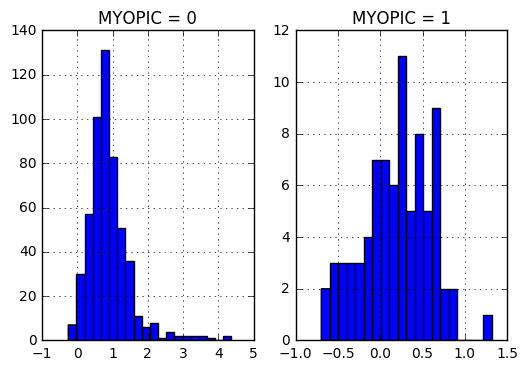

In [41]:
fig = plt.figure()

fig.add_subplot(1, 2, 1)
df['SPHEQ'][df[target]==0].hist(bins=20).set_title("MYOPIC = 0")

fig.add_subplot(1, 2, 2)
df['SPHEQ'][df[target]==1].hist(bins=20).set_title("MYOPIC = 1")

Se puede observar que la probabilidad de miopía crece cuando la refracción esférica es menor que 0.7, por lo que se puede categorizar esas variables:

In [42]:
df.loc[:, 'SPHEQ_grp'] = df['SPHEQ'].map(lambda x: 'n0' if x < 0.7 else 'n1')
get_WoE(df, 'SPHEQ_grp', target) 

Obteniendo el Woe para la variable SPHEQ_grp :
  El WoE para n0 [ 294 ] es 1.0537617225
  El WoE para n1 [ 324 ] es 4.15575319035


#### Variable AL ####

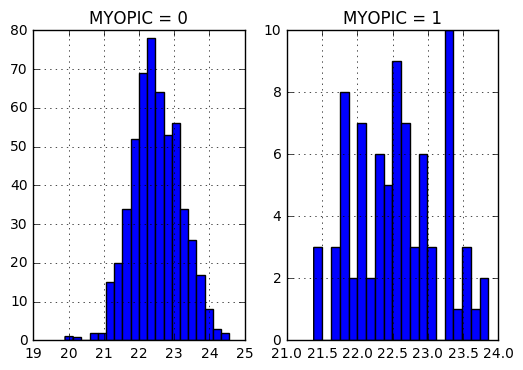

In [43]:
fig = plt.figure()

fig.add_subplot(1, 2, 1)
df['AL'][df[target]==0].hist(bins=20).set_title("MYOPIC = 0")

fig.add_subplot(1, 2, 2)
df['AL'][df[target]==1].hist(bins=20).set_title("MYOPIC = 1")

Con longitudes axiales por debajo de 22.7 es cuando más cantidad de gente con miopía hay, y a partir de 23.25 se encuentra el pico más alto de gente con miopía. Por lo tanto:

In [44]:
df.loc[:, 'AL_grp'] = df['AL'].map(lambda x: 'n0' if x < 22.7 else 'n1' if x < 23.25 else 'n2')
get_WoE(df, 'AL_grp', target) 

Obteniendo el Woe para la variable AL_grp :
  El WoE para n0 [ 387 ] es 1.93122559737
  El WoE para n1 [ 137 ] es 1.95427839873
  El WoE para n2 [ 94 ] es 1.66139765136


#### Variable ACD ####

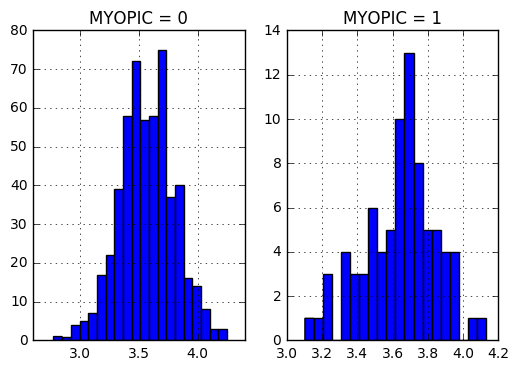

In [45]:
fig = plt.figure()

fig.add_subplot(1, 2, 1)
df['ACD'][df[target]==0].hist(bins=20).set_title("MYOPIC = 0")

fig.add_subplot(1, 2, 2)
df['ACD'][df[target]==1].hist(bins=20).set_title("MYOPIC = 1")

Para una profundidad de cámara interior entre 3.6 y 3.8 se encuentra la mayoría de la gente con miopía. Por lo tanto:

In [46]:
df.loc[:, 'ACD_grp'] = df['ACD'].map(lambda x: 'n0' if x < 3.6 else 'n1' if x < 3.8 else 'n2')
get_WoE(df, 'ACD_grp', target) 

Obteniendo el Woe para la variable ACD_grp :
  El WoE para n0 [ 324 ] es 2.3978952728
  El WoE para n1 [ 192 ] es 1.39936644269
  El WoE para n2 [ 102 ] es 1.68175857401


#### Variable LT ####

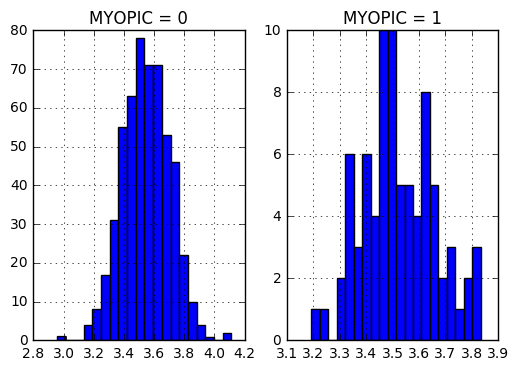

In [47]:
fig = plt.figure()

fig.add_subplot(1, 2, 1)
df['LT'][df[target]==0].hist(bins=20).set_title("MYOPIC = 0")

fig.add_subplot(1, 2, 2)
df['LT'][df[target]==1].hist(bins=20).set_title("MYOPIC = 1")

En el caso del grosor de la lente, se observa un crecimiento entre 3.4 y 3.7, por lo tanto se puede agrupar de la siguiente manera:

In [48]:
df.loc[:, 'LT_grp'] = df['LT'].map(lambda x: 'n0' if x < 3.4 else 'n1' if x < 3.7 else 'n2')
get_WoE(df, 'LT_grp', target)

Obteniendo el Woe para la variable LT_grp :
  El WoE para n0 [ 115 ] es 1.75175413461
  El WoE para n1 [ 409 ] es 1.8619637279
  El WoE para n2 [ 94 ] es 2.24542667915


#### Variable VCD ####

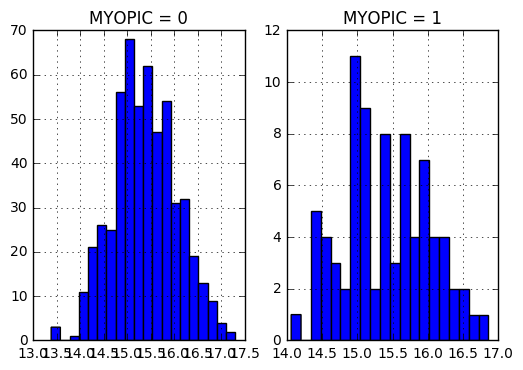

In [49]:
fig = plt.figure()

fig.add_subplot(1, 2, 1)
df['VCD'][df[target]==0].hist(bins=20).set_title("MYOPIC = 0")

fig.add_subplot(1, 2, 2)
df['VCD'][df[target]==1].hist(bins=20).set_title("MYOPIC = 1")

Por último, para la profunidad de la cámara vítrea, se observa un notable crecimiento de personas com miopía entre los valores de 15 y 16, por lo que el agrupamiento quedaría de la siguiente manera:

In [50]:
df.loc[:, 'VCD_grp'] = df['VCD'].map(lambda x: 'n0' if x < 15 else 'n1' if x < 16 else 'n2')
get_WoE(df, 'VCD_grp', target)

Obteniendo el Woe para la variable VCD_grp :
  El WoE para n0 [ 178 ] es 2.01172336762
  El WoE para n1 [ 325 ] es 1.85416503542
  El WoE para n2 [ 115 ] es 1.82253112789


### Variables transformadas ###

De la misma manera que con las variables discretas, se eliminan variables anteriores para añadir las nuevas calculadas.

In [51]:
features.remove("SPHEQ")
features.remove("AL")
features.remove("ACD")
features.remove("LT")
features.remove("VCD")

features.append("SPHEQ_grp")
features.append("AL_grp")
features.append("ACD_grp")
features.append("LT_grp")
features.append("VCD_grp")

In [52]:
for var in features:
    print var

STUDYYEAR
GENDER
MOMMY
DADMY
AGE_grp
SPORTHR_grp
READHR_grp
COMPHR_grp
STUDYHR_grp
TVHR_grp
DIOPTERHR_grp
SPHEQ_grp
AL_grp
ACD_grp
LT_grp
VCD_grp


## Creación de un modelo ##

### Creación de variables dummies ###

Gracias a la función de pandas get_dummies(), se pueden convertir variables categóricas en valores discretos.

In [53]:
data_model = pd.concat((pd.get_dummies(df['STUDYYEAR'], prefix = 'STUDYYEAR'),
                        pd.get_dummies(df['AGE_grp'], prefix = 'AGE'),
                        pd.get_dummies(df['GENDER'], prefix = 'GENDER'),
                        pd.get_dummies(df['SPORTHR_grp'], prefix = 'SPORTHR'),
                        pd.get_dummies(df['READHR_grp'], prefix = 'READHR'),
                        pd.get_dummies(df['COMPHR_grp'], prefix = 'COMPHR'),
                        pd.get_dummies(df['STUDYHR_grp'], prefix = 'STUDYHR'),
                        pd.get_dummies(df['TVHR_grp'], prefix = 'TVHR'),
                        pd.get_dummies(df['DIOPTERHR_grp'], prefix = 'DIOPTERHR'),
                        pd.get_dummies(df['MOMMY'], prefix = 'MOMMY'),
                        pd.get_dummies(df['DADMY'], prefix = 'DADMY'),
                        pd.get_dummies(df['SPHEQ_grp'], prefix = 'SPHEQ'),
                        pd.get_dummies(df['AL_grp'], prefix = 'AL'),
                        pd.get_dummies(df['ACD_grp'], prefix = 'ACD'),
                        pd.get_dummies(df['LT_grp'], prefix = 'LT'),
                        pd.get_dummies(df['VCD_grp'], prefix = 'VCD')), axis = 1)

### Eliminando variables colineales ###

Gracias al cálculo y selección con el VIF, se pueden obtener coeficientes de colinealidad entre variables para eliminar variables colineales. Después nos quedaremos con las que den un valor menor que 5.

In [54]:
from sklearn.linear_model import LinearRegression

def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = data[x_features]
        y = data[y_featue]
        
        model.fit(data[x_features], data[y_featue])
        
        result[y_featue] = 1/(1 - model.score(data[x_features], data[y_featue]))
    
    return result

def selectDataUsingVIF(data, max_VIF = 5):
    result = data.copy(deep = True)
    
    VIF = calculateVIF(result)
    
    while VIF.as_matrix().max() > max_VIF:
        col_max = np.where(VIF == VIF.as_matrix().max())[1][0]
        features = list(result.columns)
        features.remove(features[col_max])
        result = result[features]
        
        VIF = calculateVIF(result)
        
    return result

In [55]:
calculateVIF(data_model)

,STUDYYEAR_1990,STUDYYEAR_1991,STUDYYEAR_1992,STUDYYEAR_1993,STUDYYEAR_1994,STUDYYEAR_1995,AGE_5,AGE_6,AGE_7,AGE_8,...,AL_n2,ACD_n0,ACD_n1,ACD_n2,LT_n0,LT_n1,LT_n2,VCD_n0,VCD_n1,VCD_n2
VIF,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [56]:
model_vars = selectDataUsingVIF(data_model)
vif_model = calculateVIF(model_vars)

Se comprueba que todas tienen un valor menor que 5.

In [57]:
vif_model.values < 5

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]], dtype=bool)

### Separando en conjunto de muestra y de validación ###

In [100]:
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(model_vars, df[target])

### Creando el modelo y validándolo ###

In [101]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

def metricas_modelos(y_true, y_pred):
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)

    print "La matriz de confusión es "
    print confusion_matrix

    print 'Precisión:', accuracy_score(y_true, y_pred)
    print 'Exactitud:', precision_score(y_true, y_pred)
    print 'Exhaustividad:', recall_score(y_true, y_pred)
    print 'F1:', f1_score(y_true, y_pred)

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print 'AUC:', auc(false_positive_rate, recall)

    plot(false_positive_rate, recall, 'b')
    plot([0, 1], [0, 1], 'r--')
    title('AUC = %0.2f' % roc_auc)

La matriz de confusión es 
[[387   9]
 [ 31  36]]
Precisión: 0.913606911447
Exactitud: 0.8
Exhaustividad: 0.537313432836
F1: 0.642857142857
AUC: 0.757293080054


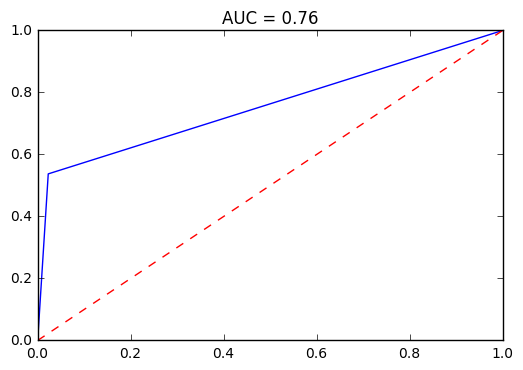

In [102]:
from sklearn.linear_model.logistic import LogisticRegression

model = LogisticRegression().fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

metricas_modelos(y_train, y_pred_train)

La matriz de confusión es 
[[135   6]
 [  6   8]]
Precisión: 0.922580645161
Exactitud: 0.571428571429
Exhaustividad: 0.571428571429
F1: 0.571428571429
AUC: 0.76443768997


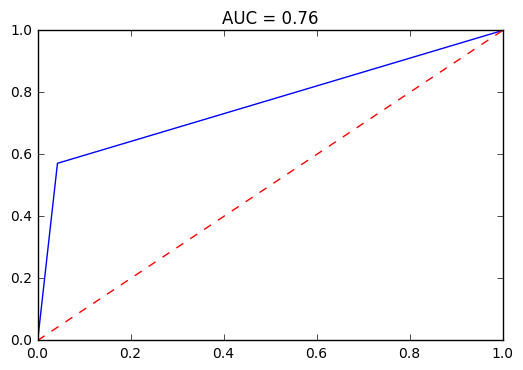

In [103]:
metricas_modelos(y_test, y_pred_test)